# Structural Estimation _ PS2

Author: Meng Yang 12245345

Date: 2020-01-20

## 1. Health Claim Amounts and the GB family of distributions

### a. Data Description and Histogram

In [13]:
import numpy as np 
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
%matplotlib notebook
import scipy.stats as sts
import scipy.optimize as opt
import scipy.integrate as integrate
import scipy.special as spc
import math 

import distributions as dst

In [14]:
claims = np.loadtxt('clms.txt', dtype = np.float)
obs = len(claims)

In [15]:
print('mean = ', np.mean(claims))
print('median = ', np.median(claims))
print('maximum = ', np.max(claims))
print('minimum = ', np.min(claims))
print('std = ', np.std(claims))

mean =  720.2779753272437
median =  172.21
maximum =  227967.25
minimum =  0.01
std =  3972.663756393663


<IPython.core.display.Javascript object>


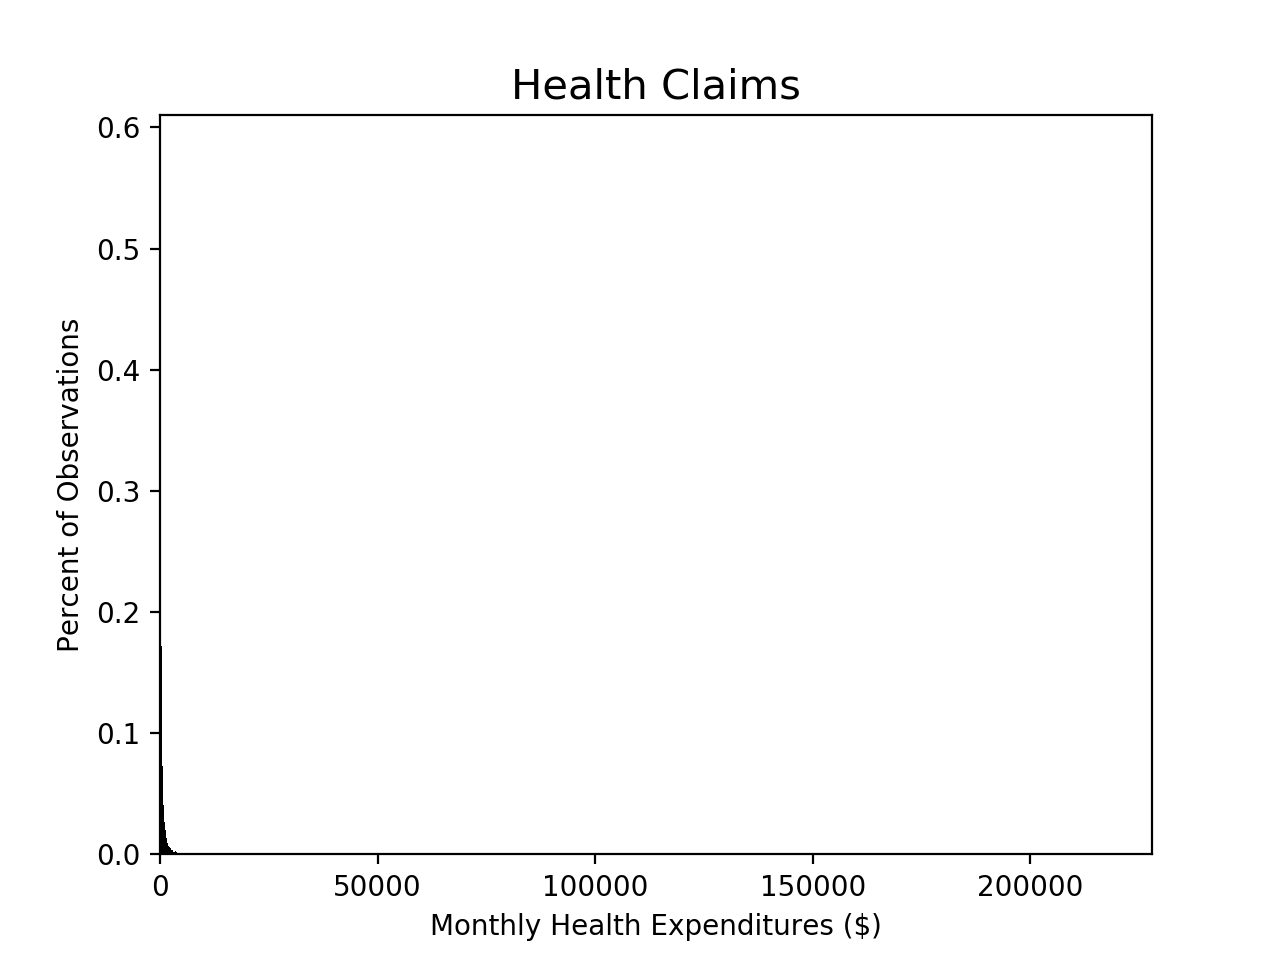

(0, 227967.25)

In [16]:
weight = (1/obs) * np.ones_like(claims)
n, bins, ignored = plt.hist(claims, 1000, weights = weight, color = 'k')
plt.title ('Health Claims', fontsize = 15)
plt.xlabel ('Monthly Health Expenditures ($)')
plt.ylabel ('Percent of Observations')
plt.xlim([0, np.max(claims)])

In [17]:
n.sum()

1.0000000000000322

<IPython.core.display.Javascript object>


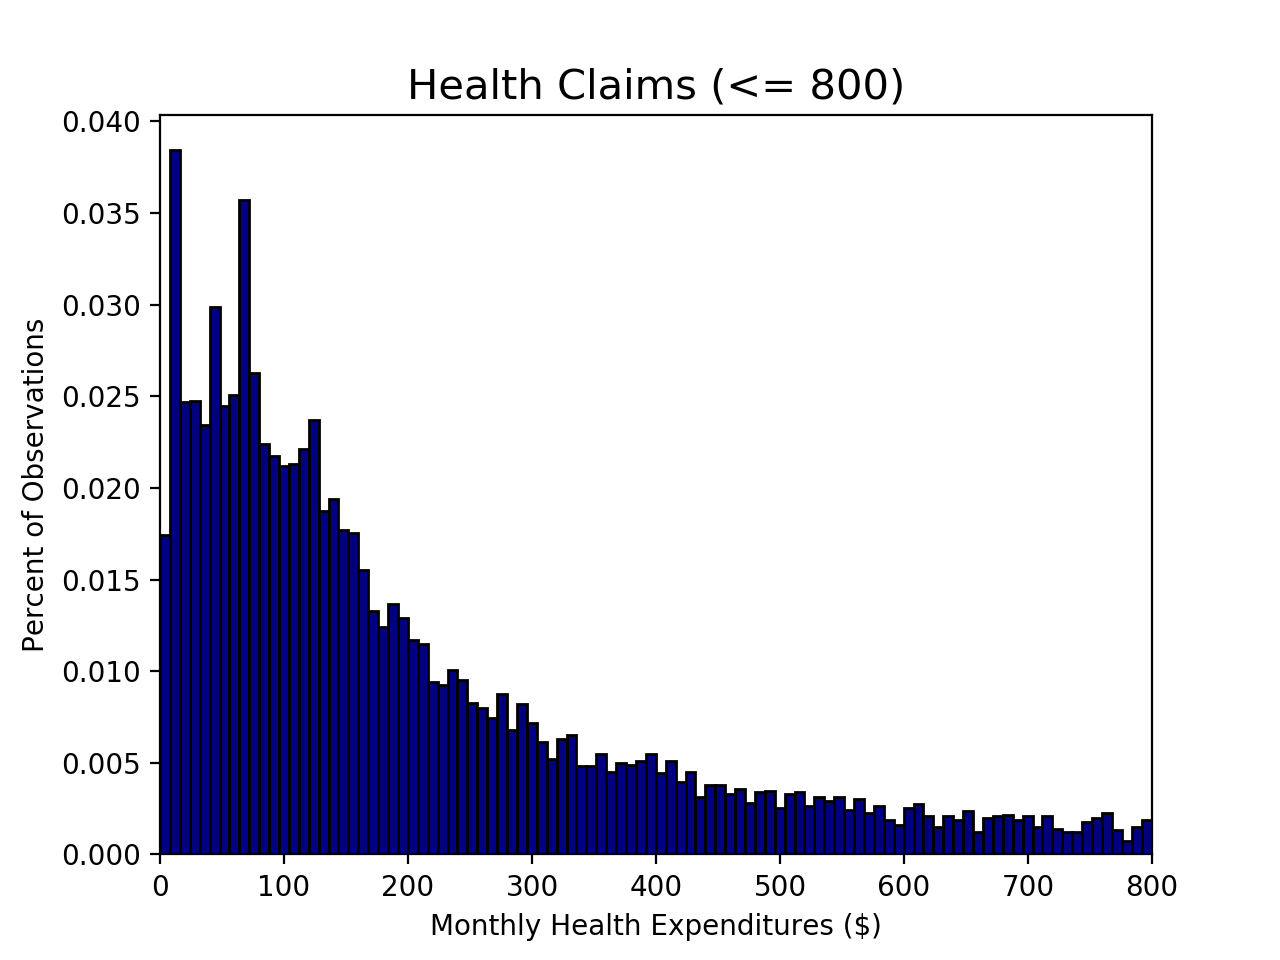

(0, 800)

In [18]:
claims_new = claims[claims <= 800]
weight_new = (1/len(claims)) * np.ones_like(claims_new)
m, bins, ignored = plt.hist(claims_new, 100, weights = weight_new, color = 'navy', edgecolor = 'black')
plt.title ('Health Claims (<= 800)', fontsize = 15)
plt.xlabel ('Monthly Health Expenditures ($)')
plt.ylabel ('Percent of Observations')
plt.xlim([0, 800])

In [19]:
m.sum()

0.8494208494208465

Prefer the second figure since we can see the distribution pattern more clearly from the second graph.

### b. MLE with gamma distribution 

$$ \text{(GA):}\quad f(x;\alpha,\beta) = \frac{1}{\beta^\alpha \Gamma(\alpha)}x^{\alpha-1}e^{-\frac{x}{\beta}},\quad x\in[0,\infty), \:\alpha,\beta>0 $$

$$ \text{where}\quad \Gamma(z)\equiv\int_0^\infty t^{z-1}e^{-t}dt $$

In [20]:
def log_lik_GA(xvals, alpha, beta):
    pdf_vals = dst.GA_pdf(xvals, alpha, beta)
    log_pdf_vals = np.log(pdf_vals)
    log_lik_vals = log_pdf_vals.sum()
    
    return log_lik_vals

def crit_GA(params, *args):
    alpha, beta = params
    xvals, = args
    log_lik_val = log_lik_GA(xvals, alpha, beta)
    neg_log_lik = - log_lik_val
    
    return neg_log_lik

In [21]:
beta_0 = np.var(claims) / np.mean(claims)
alpha_0 = np.mean(claims) / beta_0
params_0 = np.array([alpha_0, beta_0])
mle_args = (claims)
bnds = ((1e-10, None), (1e-10, None))

In [22]:
results_GA_cstr = opt.minimize(crit_GA, params_0, args = mle_args, method = 'L-BFGS-B', bounds = bnds)
results_GA_cstr

      fun: 82076.45160566256
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.        , 0.09022187])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 33
      nit: 8
   status: 0
  success: True
        x: array([2.21755323e-01, 2.19110647e+04])

In [23]:
alpha_MLE_GA, beta_MLE_GA = results_GA_cstr.x
log_lik_MLE_GA = log_lik_GA(claims, alpha_MLE_GA, beta_MLE_GA) 
print('alpha_MLE_GA = ', alpha_MLE_GA)
print('beta_MLE_GA = ', beta_MLE_GA)
print('Maximize Log Likelihood_GA = ', log_lik_MLE_GA)

alpha_MLE_GA =  0.22175532272679777
beta_MLE_GA =  21911.064699249375
Maximize Log Likelihood_GA =  -82076.45160566256


<IPython.core.display.Javascript object>


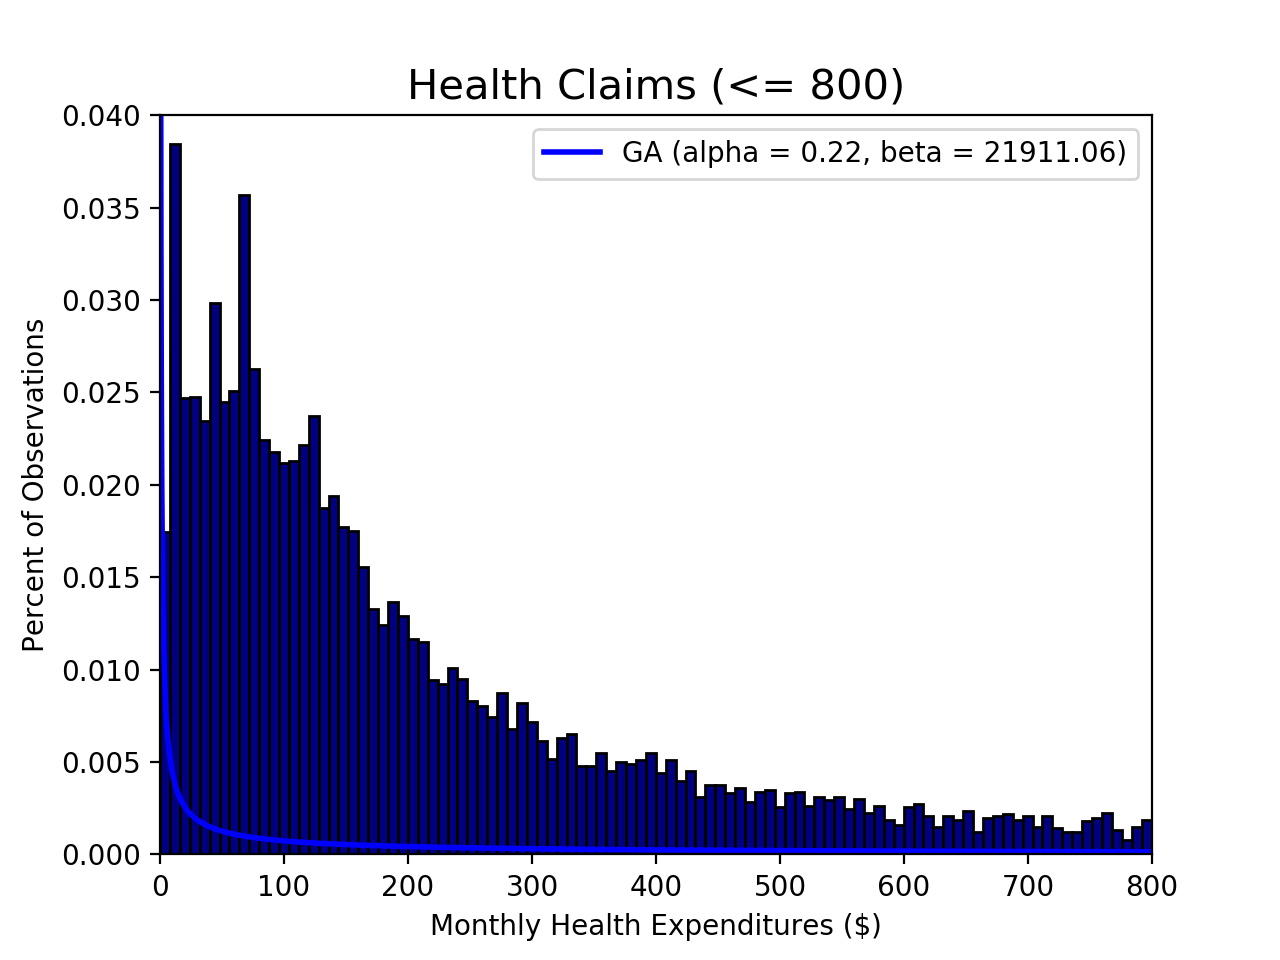

In [24]:
n, bins, ignored = plt.hist(claims_new, 100, weights = weight_new, color = 'navy', edgecolor = 'black')
plt.title ('Health Claims (<= 800)', fontsize = 15)
plt.xlabel ('Monthly Health Expenditures ($)')
plt.ylabel ('Percent of Observations')
plt.xlim([0, 800])
plt.ylim([0, 0.04])

dist_pts = np.linspace(1e-10, 800, len(claims))
plt.plot(dist_pts, dst.GA_pdf(dist_pts, alpha_MLE_GA, beta_MLE_GA), linewidth = 2, color = 'blue', label = 'GA (alpha = 0.22, beta = 21911.06)')
plt.legend(loc = 'upper right')

### c. MLE with generalized gamma distribution 
$$ \text{(GG):}\quad f(x;\alpha,\beta,m) = \frac{m}{\beta^\alpha \Gamma\left(\frac{\alpha}{m}\right)}x^{\alpha-1}e^{-\left(\frac{x}{\beta}\right)^m},\quad x\in[0,\infty), \:\alpha,\beta,m>0 $$

$$ \text{where}\quad \Gamma(z)\equiv\int_0^\infty t^{z-1}e^{-t}dt $$

In [25]:
def log_lik_GG(xvals, alpha, beta, m):
    pdf_vals = dst.GG_pdf(xvals, alpha, beta, m)
    log_pdf_vals = np.log(pdf_vals)
    log_lik_vals = log_pdf_vals.sum()
    
    return log_lik_vals

def crit_GG(params, *args):
    alpha, beta, m = params
    xvals, = args
    log_lik_val = log_lik_GG(xvals, alpha, beta, m)
    neg_log_lik = - log_lik_val

    return neg_log_lik

In [26]:
alpha_0 = alpha_MLE_GA
beta_0 = beta_MLE_GA
m_0 = 1
params_0 = np.array([alpha_0, beta_0, m_0])
bnds = ((1e-10, None), (1e-10, None), (1e-10, None))

In [27]:
results_GG_cstr = opt.minimize(crit_GG, params_0, args = mle_args, method = 'L-BFGS-B', bounds = bnds)
results_GG_cstr

      fun: 82076.44679085154
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.65544111,  0.09022187, -1.04482751])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 24
      nit: 2
   status: 0
  success: True
        x: array([2.21737618e-01, 2.19110644e+04, 9.97091564e-01])

In [28]:
alpha_MLE_GG, beta_MLE_GG, m_MLE_GG = results_GG_cstr.x
log_lik_MLE_GG = log_lik_GG(claims, alpha_MLE_GG, beta_MLE_GG, m_MLE_GG) 
print('alpha_MLE_GG = ', alpha_MLE_GG)
print('beta_MLE_GG = ', beta_MLE_GG)
print('m_MLE_GG = ', m_MLE_GG)
print('Maximize Log Likelihood_GG = ', log_lik_MLE_GG)

alpha_MLE_GG =  0.22173761759457977
beta_MLE_GG =  21911.064431816903
m_MLE_GG =  0.9970915637772736
Maximize Log Likelihood_GG =  -82076.44679085154


<IPython.core.display.Javascript object>


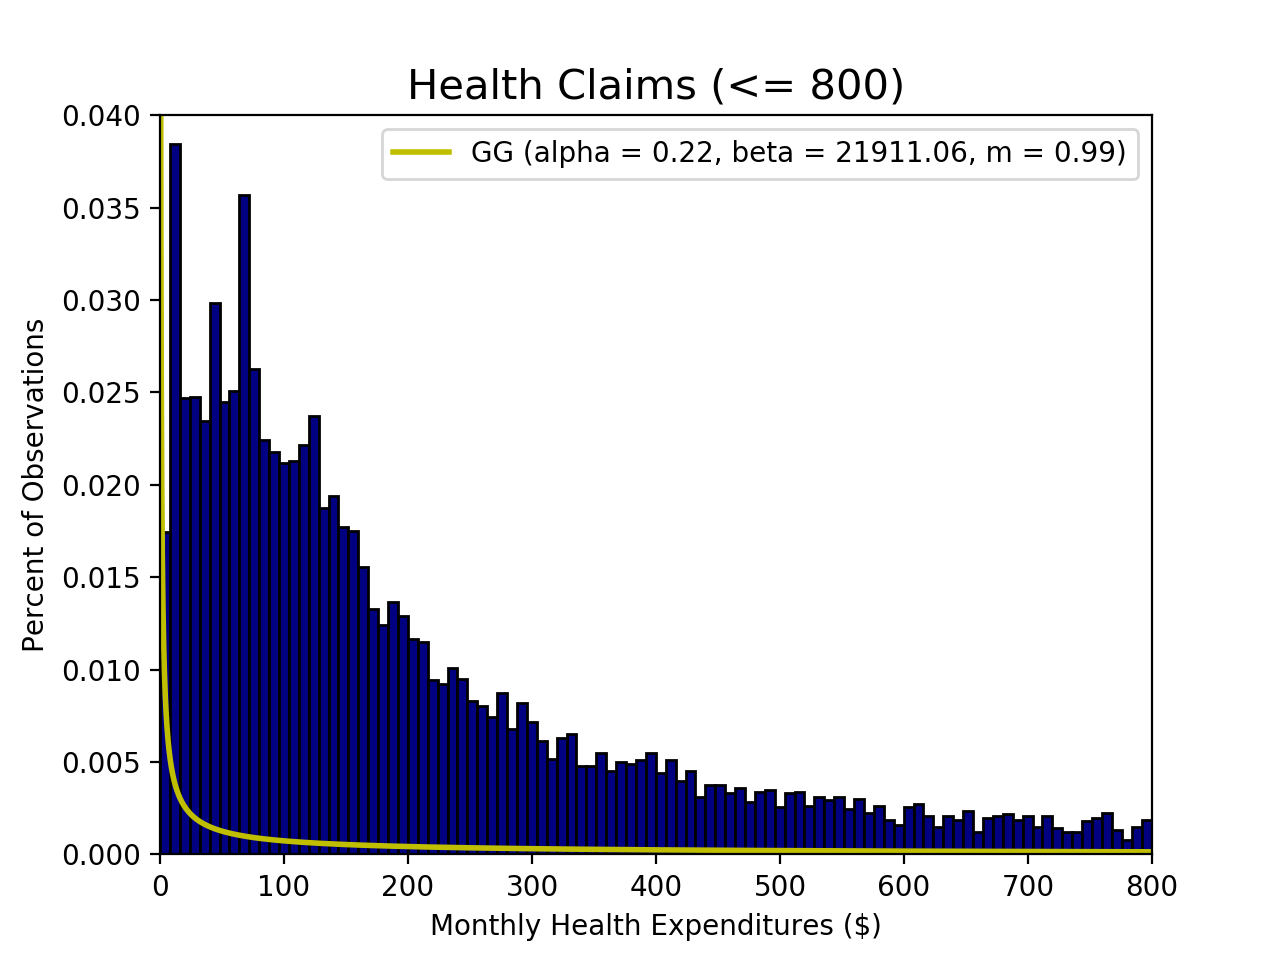

In [29]:
n, bins, ignored = plt.hist(claims_new, 100, weights = weight_new, color = 'navy', edgecolor = 'black')
plt.title ('Health Claims (<= 800)', fontsize = 15)
plt.xlabel ('Monthly Health Expenditures ($)')
plt.ylabel ('Percent of Observations')
plt.xlim([0, 800])
plt.ylim([0, 0.04])

dist_pts = np.linspace(1e-10, 800, len(claims))
plt.plot(dist_pts, dst.GG_pdf(dist_pts, alpha_MLE_GG, beta_MLE_GG, m_MLE_GG), linewidth = 2,
         color = 'y', label = 'GG (alpha = 0.22, beta = 21911.06, m = 0.99)')
plt.legend(loc = 'upper right')

### d. MLE with generalized beta 2 distribution 
$$ \text{(GB2):}\quad f(x;a,b,p,q) = \frac{a x^{ap-1}}{b^{ap}B(p,q)\left(1 + \left(\frac{x}{b}\right)^a\right)^{p+q}},\quad x\in[0,\infty), \:a,b,p,q>0 $$

$$ \quad\text{where}\quad B(v,w)\equiv\int_0^1 t^{v-1}(1-t)^{w-1}dt $$

In [30]:
def log_lik_GB2(xvals, a, b, p, q):
    pdf_vals = dst.GB2_pdf(xvals, a, b, p, q)
    log_pdf_vals = np.log(pdf_vals)
    log_lik_vals = log_pdf_vals.sum()
        
    return log_lik_vals

def crit_GB2(params, *args):
    a, b, p, q = params
    xvals, = args
    log_lik_val = log_lik_GB2(xvals, a, b, p, q)
    neg_log_lik = - log_lik_val
 
    return neg_log_lik

In [31]:
a_0 = alpha_MLE_GG
b_0 = beta_MLE_GG
p_0 = m_MLE_GG
q_0 = 10000
params_0 = np.array([a_0, b_0, p_0, q_0])
bnds = ((1e-10, None), (1e-10, None), (1e-10, None), (1e-10, 94))

In [32]:
results_GB2_cstr = opt.minimize(crit_GB2, params_0, args= mle_args, method="L-BFGS-B", bounds = bnds)
results_GB2_cstr

      fun: 74862.20981500167
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.858563  ,  0.00145519, -0.39290171,  0.22700988])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 775
      nit: 93
   status: 0
  success: True
        x: array([1.13363453e-01, 2.19248579e+04, 5.49314731e+01, 9.39999987e+01])

In [33]:
a_MLE_GB2, b_MLE_GB2, p_MLE_GB2, q_MLE_GB2 = results_GB2_cstr.x
log_lik_MLE_GB2 = log_lik_GB2(claims, a_MLE_GB2, b_MLE_GB2, p_MLE_GB2,  q_MLE_GB2) 
print('a_MLE_GB2 = ', a_MLE_GB2)
print('b_MLE_GB2 = ', b_MLE_GB2)
print('p_MLE_GB2 = ', p_MLE_GB2)
print('q_MLE_GB2 = ', q_MLE_GB2)
print('Maximize Log Likelihood_GB2 = ', log_lik_MLE_GB2)

a_MLE_GB2 =  0.11336345283229907
b_MLE_GB2 =  21924.857878335693
p_MLE_GB2 =  54.931473132850776
q_MLE_GB2 =  93.99999870055183
Maximize Log Likelihood_GB2 =  -74862.20981500167


<IPython.core.display.Javascript object>


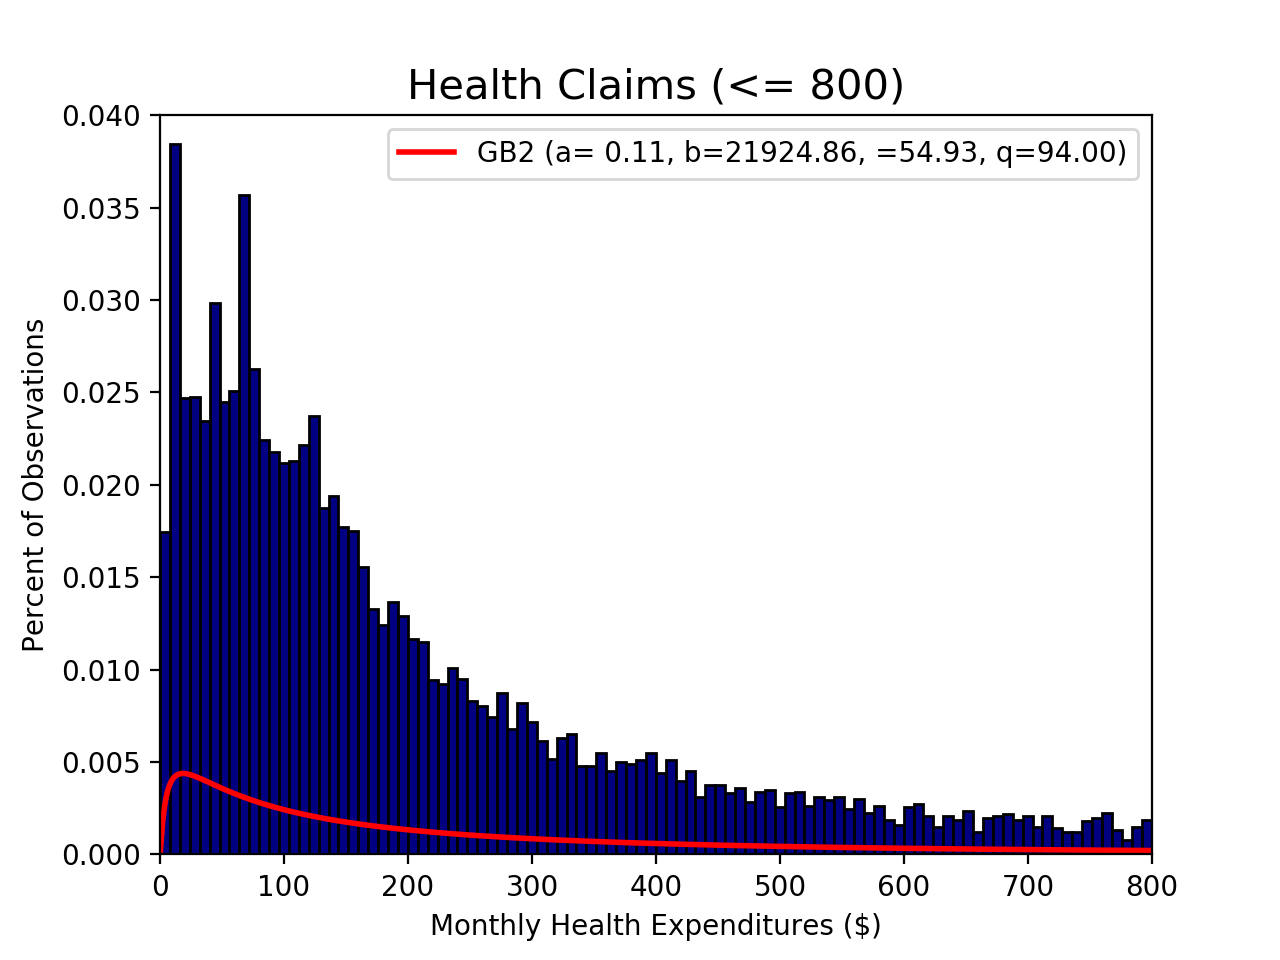

In [34]:
n, bins, ignored = plt.hist(claims_new, 100, weights = weight_new, color = 'navy', edgecolor = 'black')
plt.title ('Health Claims (<= 800)', fontsize = 15)
plt.xlabel ('Monthly Health Expenditures ($)')
plt.ylabel ('Percent of Observations')
plt.xlim([0, 800])
plt.ylim([0, 0.04])

dist_pts = np.linspace(1e-10, 800, len(claims))
plt.plot(dist_pts, dst.GB2_pdf(dist_pts, a_MLE_GB2, b_MLE_GB2, p_MLE_GB2, q_MLE_GB2), linewidth = 2,
         color = 'r', label = 'GB2 (a= 0.11, b=21924.86, =54.93, q=94.00)')
plt.legend(loc = 'upper right')

<IPython.core.display.Javascript object>


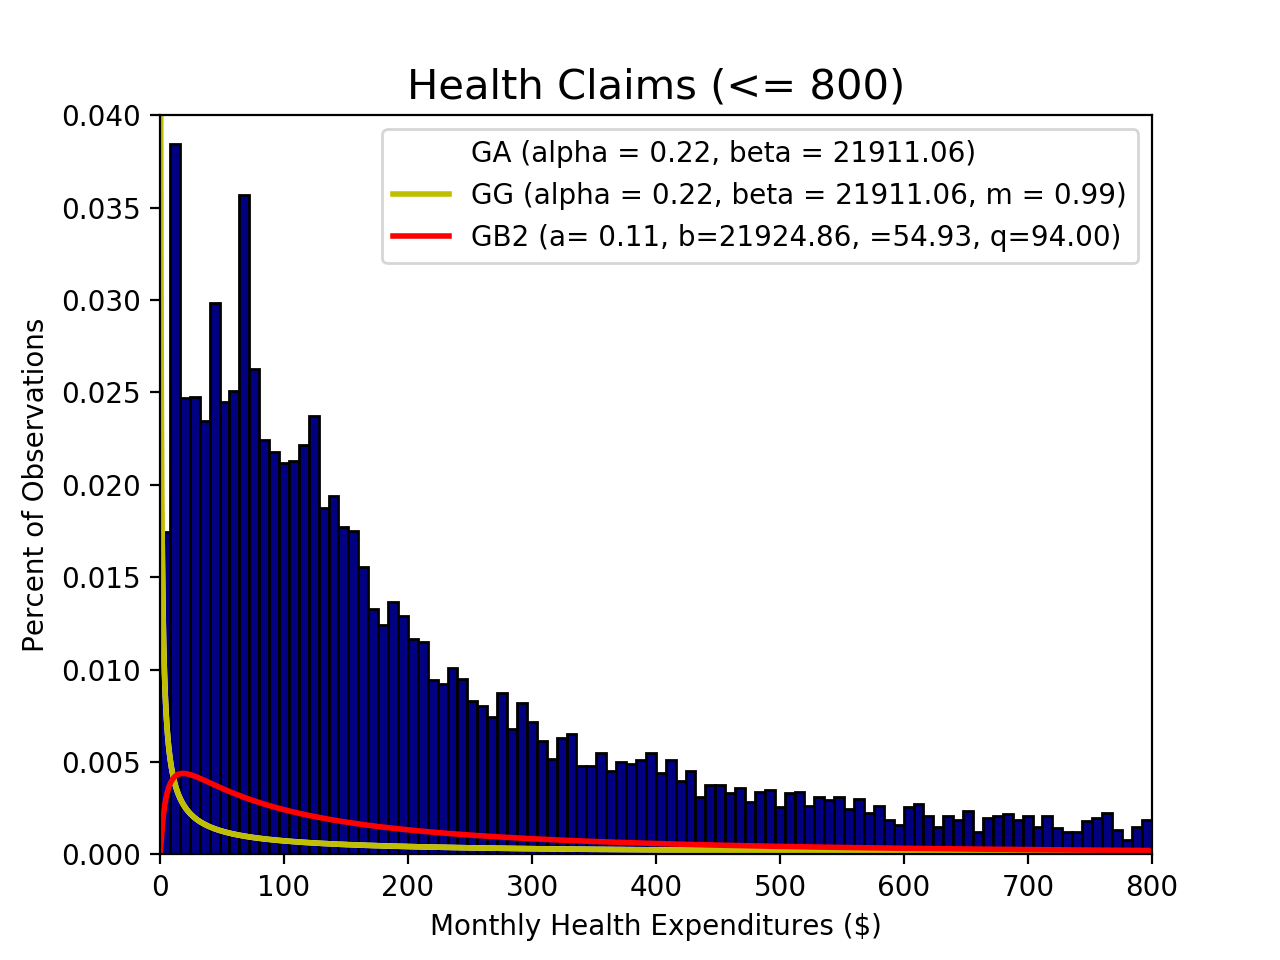

In [35]:
n, bins, ignored = plt.hist(claims_new, 100, weights = weight_new, color = 'navy', edgecolor = 'black')
plt.title ('Health Claims (<= 800)', fontsize = 15)
plt.xlabel ('Monthly Health Expenditures ($)')
plt.ylabel ('Percent of Observations')
plt.xlim([0, 800])
plt.ylim([0, 0.04])

dist_pts = np.linspace(1e-10, 800, len(claims))
plt.plot(dist_pts, dst.GA_pdf(dist_pts, alpha_MLE_GA, beta_MLE_GA), linewidth = 2, 
         color = 'white', label = 'GA (alpha = 0.22, beta = 21911.06)')
plt.plot(dist_pts, dst.GG_pdf(dist_pts, alpha_MLE_GG, beta_MLE_GG, m_MLE_GG), linewidth = 2,
         color = 'y', label = 'GG (alpha = 0.22, beta = 21911.06, m = 0.99)')
plt.plot(dist_pts, dst.GB2_pdf(dist_pts, a_MLE_GB2, b_MLE_GB2, p_MLE_GB2, q_MLE_GB2), linewidth = 2,
         color = 'r', label = 'GB2 (a= 0.11, b=21924.86, =54.93, q=94.00)')
plt.legend(loc = 'upper right')

### e. Likelihood Ratio Test
$$ LR(\tilde{\theta}|\hat{\theta}_{MLE}) = 2\Bigl(\ln\ell(\hat{\theta}_{MLE}) - \ln\ell(\tilde{\theta})\Bigr) \sim \chi^2(p) $$
$$ GG(\alpha,\beta,m) = \lim_{q\rightarrow\infty}GB2\left(a=m,b=q^{1/m}\beta,p=\frac{\alpha}{m},q\right) $$
$$ GA(\alpha,\beta) = GG(\alpha,\beta,m=1) $$

In [36]:
LR_b = 2 * (log_lik_MLE_GB2 - log_lik_MLE_GA)
pval_h0_b = 1.0 - sts.chi2.cdf(LR_b, 4)
print('chi squared of H_0_b with 4 degrees of freedom p-value = ', pval_h0_b)

LR_c = 2 * (log_lik_MLE_GB2 - log_lik_MLE_GG)
pval_h0_c = 1.0 - sts.chi2.cdf(LR_c, 4)
print('chi squared of H_0_c with 4 degrees of freedom p-value = ', pval_h0_c)

chi squared of H_0_b with 4 degrees of freedom p-value =  0.0
chi squared of H_0_c with 4 degrees of freedom p-value =  0.0


### f. Hypthesis Testing

In [37]:
p_GA = integrate.quad(lambda x: dst.GA_pdf(x, alpha_MLE_GA, beta_MLE_GA), 1e-10, 1000)[0]
p_GB2 = integrate.quad(lambda x: dst.GB2_pdf(x, a_MLE_GB2, b_MLE_GB2, p_MLE_GB2, q_MLE_GB2), 1e-10, 1000)[0]

print('Assuming GA distribution, prob of health claim higher than $1000: ', 1-p_GA)
print('Assumeing GB2 distribution, prob of health claim higher than $1000: ', 1-p_GB2)

Assuming GA distribution, prob of health claim higher than $1000:  0.4519597444786656
Assumeing GB2 distribution, prob of health claim higher than $1000:  0.13062539899950565


## 2. MLE Estimation of Simple Macroeconomic Model 
### a. MLE with $(w_t, k_t)$ 
$$w_t-(1-\alpha)e^{z_t}(k_t)^{\alpha}=0$$
$$z_t=\rho z_{t-1}+(1-\rho)\mu+\varepsilon_t \quad z_t \sim N(\rho z_{t-1}+(1-\rho)\mu, {\sigma}^2)$$
$$z_t=logw_t-log(1-\alpha)-\alpha logk_t$$

In [38]:
c, k, w, r = np.loadtxt('MacroSeries.txt', unpack=True, delimiter=",", dtype = np.float)

In [39]:
def log_lik_norm(z, mu, sigma):
    log_vals = -( (z - mu) ** 2) / (2 * sigma ** 2) -np.log(sigma * math.sqrt(2 * math.pi) )
    log_lik_norm = log_vals.sum()
    return log_lik_norm

    
def crit_wk(params, *args):
    alpha, rho, mu, sigma = params
    w, k = args
    z = np.log(w) - np.log(1-alpha) - alpha * np.log(k)
    z_lag = np.roll(z,1)
    z_lag[0] = mu
    neg_log_lik = - log_lik_norm (z, rho * z_lag + (1-rho) * mu, sigma)
    
    return neg_log_lik

Use the empirical capital share of output as initial value of alpha. Set high initial value for rho since we expect that the TFP to be consistent across time.

In [40]:
alpha_0 = np.sum(k)/(np.sum(k) + np.sum(w))
rho_0 = 0.7
z = np.log(w) - np.log(1 - alpha_0) - alpha_0 * np.log(k)
mu_0 = z [0]
sigma_0 = np.std(z)
params_0 = np.array([alpha_0, rho_0, mu_0, sigma_0])
bnds = ((1e-10, 1-1e-10), (-1+1e-10, 1-1e-10), (1e-10, None), (1e-10, None))

In [41]:
results_cstr_wk = opt.minimize(crit_wk, params_0, args=((w, k)), method="L-BFGS-B", bounds = bnds )
results_cstr_wk

      fun: -96.70690806796091
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.01038813, -0.00057838, -0.00072902,  0.0104734 ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 185
      nit: 32
   status: 0
  success: True
        x: array([0.45751623, 0.7204865 , 9.52272008, 0.09199667])

In [42]:
alpha_MLE_wk, rho_MLE_wk, mu_MLE_wk, sigma_MLE_wk =results_cstr_wk.x
print('alpha_MLE_wk = ', alpha_MLE_wk)
print('rho_MLE_wk = ', rho_MLE_wk)
print('mu_MLE_wk = ', mu_MLE_wk)
print('sigma_MLE_wk = ', sigma_MLE_wk)

vcv_mle = (results_cstr_wk.hess_inv).matmat(np.eye(4))

stderr_alpha_mle = np.sqrt(vcv_mle[0,0])
stderr_rho_mle = np.sqrt(vcv_mle[1,1])
stderr_mu_mle = np.sqrt(vcv_mle[2,2])
stderr_sig_mle = np.sqrt(vcv_mle[3,3])
print('VCV(MLE) = ', vcv_mle)
print('Standard error for alpha estimate = ', stderr_alpha_mle)
print('Standard error for rho estimate = ', stderr_rho_mle)
print('Standard error for mu estimate = ', stderr_mu_mle)
print('Standard error for sigma estimate = ', stderr_sig_mle)

alpha_MLE_wk =  0.45751623143806586
rho_MLE_wk =  0.7204864974460844
mu_MLE_wk =  9.522720077137105
sigma_MLE_wk =  0.09199667447879084
VCV(MLE) =  [[ 1.51544571e+01  1.08214268e+01 -2.10816257e+02 -2.39580139e+00]
 [ 1.08214268e+01  7.99046870e+00 -1.50292871e+02 -1.85405904e+00]
 [-2.10816257e+02 -1.50292871e+02  2.93308411e+03  3.31190526e+01]
 [-2.39580139e+00 -1.85405904e+00  3.31190526e+01  4.94278685e-01]]
Standard error for alpha estimate =  3.8928726054481544
Standard error for rho estimate =  2.8267417116014424
Standard error for mu estimate =  54.15795516956665
Standard error for sigma estimate =  0.7030495607315225


### b. MLE with  $(r_t, k_t)$
$$r_t-\alpha e^{z_t}k_t^{\alpha-1}=0$$
$$z_t=(1-\alpha)logk_t+logr_t-log\alpha$$

In [43]:
def crit_rk(params, *args):
    alpha, rho, mu, sigma = params
    r, k = args
    z = (1 - alpha) * np.log(k) + np.log(r) - np.log(alpha)
    z_lag = np.roll(z,1)
    z_lag[0] = mu
    neg_log_lik = - log_lik_norm (z, rho * z_lag + (1-rho) * mu, sigma)
    
    return neg_log_lik

In [44]:
results_cstr_rk = opt.minimize(crit_rk, params_0, args = ((r,k)), method = 'L-BFGS-B', bounds = bnds)
results_cstr_rk

      fun: -96.70690801510555
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.28643795e-03, -2.13162821e-05, -2.84217094e-04,  7.58859642e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 185
      nit: 28
   status: 0
  success: True
        x: array([0.45747369, 0.72052017, 9.37105922, 0.09199626])

In [45]:
alpha_MLE_rk, rho_MLE_rk, mu_MLE_rk, sigma_MLE_rk =results_cstr_rk.x
print('alpha_MLE_rk = ', alpha_MLE_rk)
print('rho_MLE_rk = ', rho_MLE_rk)
print('mu_MLE_rk = ', mu_MLE_rk)
print('sigma_MLE_rk = ', sigma_MLE_rk)

vcv_mle = (results_cstr_rk.hess_inv).matmat(np.eye(4))

stderr_alpha_mle = np.sqrt(vcv_mle[0,0])
stderr_rho_mle = np.sqrt(vcv_mle[1,1])
stderr_mu_mle = np.sqrt(vcv_mle[2,2])
stderr_sig_mle = np.sqrt(vcv_mle[3,3])
print('VCV(MLE) = ', vcv_mle)
print('Standard error for alpha estimate = ', stderr_alpha_mle)
print('Standard error for rho estimate = ', stderr_rho_mle)
print('Standard error for mu estimate = ', stderr_mu_mle)
print('Standard error for sigma estimate = ', stderr_sig_mle)

alpha_MLE_rk =  0.4574736869802028
rho_MLE_rk =  0.7205201692687961
mu_MLE_rk =  9.371059221511201
sigma_MLE_rk =  0.09199626335999808
VCV(MLE) =  [[ 3.76926311e+00 -2.92928894e+00 -6.25510699e+01 -6.61470396e-01]
 [-2.92928894e+00  6.91996426e+00  4.90824178e+01  1.15972111e-01]
 [-6.25510699e+01  4.90824178e+01  1.03815218e+03  1.09288745e+01]
 [-6.61470396e-01  1.15972111e-01  1.09288745e+01  1.51247708e-01]]
Standard error for alpha estimate =  1.9414590162330916
Standard error for rho estimate =  2.6305824953028445
Standard error for mu estimate =  32.220368950040985
Standard error for sigma estimate =  0.38890578237483786


### c. 
when $r_t=1, z_t = z^*=(1-\alpha)logk_t-log\alpha$
$$z_t \sim N(\rho z_{t-1}+(1-\rho)\mu$$

In [46]:
z_star = (1-alpha_MLE_wk) * np.log(7500000) - np.log(alpha_MLE_wk)
mu_star = rho_MLE_wk * 10 + (1-rho_MLE_wk) * mu_MLE_wk
print(z_star, mu_star)

9.369685332305002 9.86659381706193


In [82]:
prob = integrate.quad(lambda x: sts.norm.pdf(x, mu_MLE_wk, sigma_MLE_wk), z_star, math.inf)[0]
print('Pobablity that interest rate greater than 1 is ', prob)

Pobablity that interest rate greater than 1 is  0.9518919314154524
